In [20]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
import cv2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
e_path1 = 'BC_Grade1/BC_IDC_Grade_1/Samples/enhanced'
e_path2 = 'BC_Grade2/BC_IDC_Grade_2/Samples/enhanced'
e_path3 = 'BC_Grade3/BC_IDC_Grade_3/Samples/enhanced'

In [3]:
def load_images_from_folder(folder_path, target_size=(299, 299)):
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith(('.JPG', '.jpg'))]
    images = []

    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, target_size)   
            images.append(img_resized)
    
    return np.array(images)

In [4]:
BCStage1 = load_images_from_folder(e_path1)
BCStage2 = load_images_from_folder(e_path2)
BCStage3 = load_images_from_folder(e_path3)

labels_stage1 = np.zeros((BCStage1.shape[0],)) 
labels_stage2 = np.ones((BCStage2.shape[0],))    
labels_stage3 = 2 * np.ones((BCStage3.shape[0],)) 

X = np.concatenate([BCStage1, BCStage2 ,BCStage3 ], axis=0)
y = np.concatenate([labels_stage1, labels_stage2, labels_stage3], axis=0)

In [5]:
X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=36)

In [6]:
X_val, X_test, y_val, y_test = train_test_split(X_test_temp, y_test_temp, test_size=0.5, random_state=36)

In [7]:
dataAug = ImageDataGenerator(
    rotation_range=40,            
    width_shift_range=0.2,        
    height_shift_range=0.2,      
    shear_range=0.2,             
    zoom_range=[1.0, 1.2],              
    horizontal_flip=True,  
    rescale=1./255
)

In [8]:
dataAug.fit(X_train)

In [9]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [10]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [11]:
for layer in base_model.layers:
    layer.trainable = False
       
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  
x = Dense(3, activation='softmax')(x)  
INCmodel = Model(base_model.input, x)
INCmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [ ]:
for layer in base_model.layers:
    layer.trainable = False
    
INCmodel = Sequential()
INCmodel.add(base_model)
INCmodel.add(GlobalAveragePooling2D())
INCmodel.add(Dense(512, activation='relu'))
INCmodel.add(BatchNormalization())
INCmodel.add(Dropout(0.5))
INCmodel.add(Dense(3, activation='softmax'))

INCmodel.summary()

In [12]:
INCmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
INCmodel.fit(X_train, y_train,
           validation_data=(X_val, y_val),
           epochs=20,
           batch_size=32)

Epoch 1/20
24/24 [==============================] - 44s 2s/step - loss: 1.6510 - accuracy: 0.3650 - val_loss: 1.0876 - val_accuracy: 0.4348
Epoch 2/20
24/24 [==============================] - 45s 2s/step - loss: 1.2178 - accuracy: 0.5075 - val_loss: 1.0644 - val_accuracy: 0.4783
Epoch 3/20
24/24 [==============================] - 44s 2s/step - loss: 1.1132 - accuracy: 0.5699 - val_loss: 1.0544 - val_accuracy: 0.5326
Epoch 4/20
24/24 [==============================] - 46s 2s/step - loss: 0.9724 - accuracy: 0.5821 - val_loss: 0.9267 - val_accuracy: 0.6087
Epoch 5/20
24/24 [==============================] - 46s 2s/step - loss: 0.8824 - accuracy: 0.6364 - val_loss: 0.9088 - val_accuracy: 0.5761
Epoch 6/20
24/24 [==============================] - 48s 2s/step - loss: 0.8160 - accuracy: 0.6486 - val_loss: 0.9319 - val_accuracy: 0.5870
Epoch 7/20
24/24 [==============================] - 50s 2s/step - loss: 0.7887 - accuracy: 0.6554 - val_loss: 0.8723 - val_accuracy: 0.5978
Epoch 8/20
24/24 [==

In [14]:
test_loss, test_accuracy = INCmodel.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

3/3 [==============================] - 4s 1s/step - loss: 1.0347 - accuracy: 0.6022
Test accuracy: 60.22%


In [15]:
predictions = INCmodel.predict(X_test)  
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test

f1 = f1_score(true_classes, predicted_classes, average='weighted')
print("F1 Score:", f1)

3/3 [==============================] - 5s 1s/step
F1 Score: 0.5932347574864761


3/3 [==============================] - 4s 1s/step


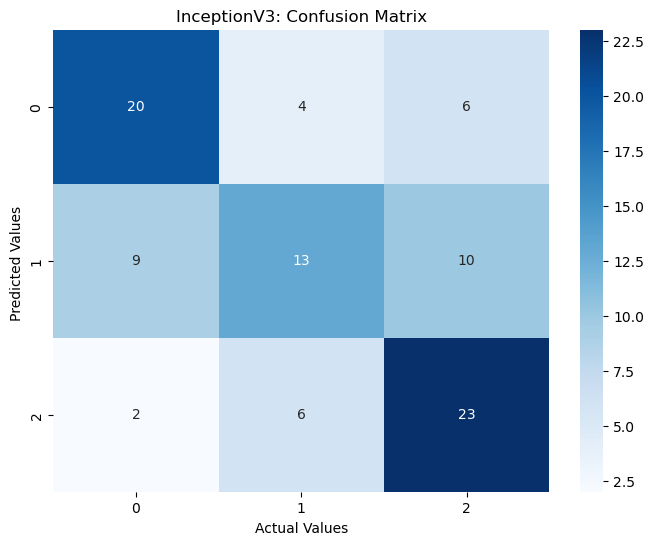

In [23]:
predictions = INCmodel.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_test, predicted_labels)

class_names = ['0', '1', '2'] 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values ')
plt.title('InceptionV3: Confusion Matrix')
plt.show()

3/3 [==============================] - 4s 1s/step


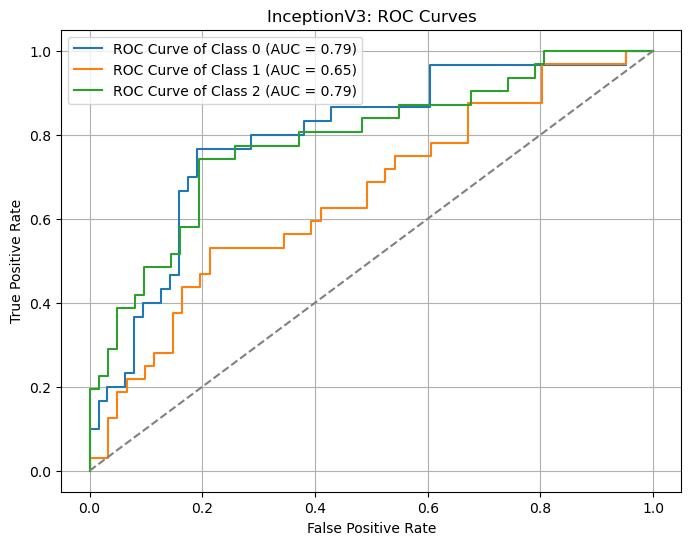

In [24]:
y_pred_prob = INCmodel.predict(X_test)

num_classes = y_pred_prob.shape[1]
fpr = {}
tpr = {}
auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_prob[:, i])
    auc[i] = roc_auc_score(y_test == i, y_pred_prob[:, i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC Curve of Class {i} (AUC = {auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('InceptionV3: ROC Curves')
plt.legend()
plt.grid()
plt.show()